# we are scinetists

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import h5py

Mount data

In [3]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Group 4/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-A7MSZ6V8eP_xZaDJ_j7yN9ddVL8-jgm/Group 4


Load data

In [4]:
root = os.getcwd()
data_path = root + '/eeg_full/'
df = pd.read_csv(data_path+'S1_patient_summary.csv')
hf = h5py.File(data_path+'S1.h5', 'r')
df['Type'] = df['Type'].replace({'c':0, 'a':1})
dat_tensor = np.zeros((len(df), 64, 256))
dat_targets = np.zeros(len(df))
for i in range(len(df)):
    
    pat = df.iloc[i]['Patient']
    tri = '%03d'%df.iloc[i]['Trial']
    
    fname = pat+'.rd.'+tri
    
    dat = np.array(hf.get(fname))
    
    dat_tensor[i] = dat
    dat_targets[i] = df.iloc[i]['Type']

# Filter

In [5]:
from numpy.fft import rfft, rfftfreq, irfft

In [8]:
fs = 256
freq_tensor = np.zeros((len(df), 64, 5))
eeg_bands = [(0.01, 4), (4, 8), (8, 12), (12, 30), (30, 45)] # delta, theta, alpha, beta, gamma
for i in range(len(df)):
  band_vals = np.zeros((64,5))
  for j in range(64):
      data = dat_tensor[i,j]
      fft_vals = np.absolute(rfft(data))
      fft_freq = rfftfreq(len(data), 1.0/fs)
      for k in range(5):
        band = eeg_bands[k]
        band_ix = (fft_freq >= band[0]) & (fft_freq <= band[1])
        band_vals[j,k] = np.mean(fft_vals[band_ix])
  freq_tensor[i] = band_vals

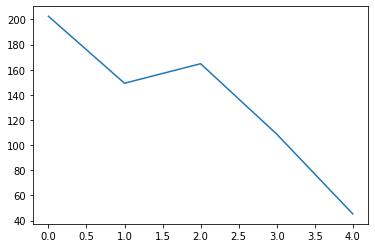

In [9]:
plt.plot(freq_tensor[0,0])

Split data

In [10]:
from sklearn.model_selection import train_test_split
train_tensor, test_tensor, train_target, test_target = train_test_split(
                                            freq_tensor, dat_targets,
                                            test_size=0.2, random_state=0)

Build model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [16]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64,5,1), 
                        bias_regularizer=regularizers.l1(1e-5),
                        activity_regularizer=regularizers.l1(1e-5),
                        kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Flatten())
model.add(layers.Dense(19, activation='relu',
                       bias_regularizer=regularizers.l1(1e-5),
                       activity_regularizer=regularizers.l1(1e-5),
                       kernel_regularizer=regularizers.l1(1e-5)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 3, 32)         320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 1, 32)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 19)                12179     
                                                                 
 dense_1 (Dense)             (None, 1)                 20        
                                                                 
Total params: 12,519
Trainable params: 12,519
Non-trainable params: 0
__________________________________________________

In [17]:
history = model.fit(train_tensor, train_target, 
                    epochs = 400,
                    batch_size = 10,
                    validation_split = .2)

Epoch 1/400
351/351 [==============================] - 14s 5ms/step - loss: 3.4679 - binary_accuracy: 0.6027 - val_loss: 1.4296 - val_binary_accuracy: 0.6112
Epoch 2/400
351/351 [==============================] - 2s 4ms/step - loss: 1.1057 - binary_accuracy: 0.6421 - val_loss: 1.0022 - val_binary_accuracy: 0.6830
Epoch 3/400
351/351 [==============================] - 1s 4ms/step - loss: 0.8039 - binary_accuracy: 0.6584 - val_loss: 0.8075 - val_binary_accuracy: 0.6876
Epoch 4/400
351/351 [==============================] - 1s 4ms/step - loss: 0.7166 - binary_accuracy: 0.6792 - val_loss: 0.7446 - val_binary_accuracy: 0.6944
Epoch 5/400
351/351 [==============================] - 1s 4ms/step - loss: 0.6681 - binary_accuracy: 0.7009 - val_loss: 0.7405 - val_binary_accuracy: 0.7024
Epoch 6/400
351/351 [==============================] - 1s 4ms/step - loss: 0.6485 - binary_accuracy: 0.7043 - val_loss: 0.7585 - val_binary_accuracy: 0.6534
Epoch 7/400
351/351 [==============================] - 1s

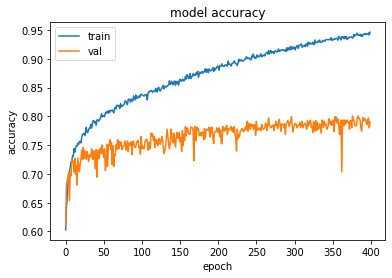

In [18]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [19]:
test_target_probs = model.predict(test_tensor).flatten()
c_range = np.linspace(0,1,100)
# Computing the accuracies
accuracies = np.ones(len(c_range))

for i in range(len(c_range)):
    c = c_range[i]
    # Compute accuracy as before but with threshold c
    accuracies[i] = np.sum(1*(test_target_probs>c)
                           ==test_target)/len(test_target)
np.max(accuracies), c_range[np.argmax(accuracies)]

(0.8147810218978102, 0.494949494949495)